# Exercise 4.4

As 2 time series data sequences usually vary in lengths and have local phase shifts (for example, it is not
straight forward to use popular distance metrics such as Euclidean distance on time series data. Dynamic
Time Warping (DTW)[8][9] is a similarity measuring technique often used for the above described scenarios.
Simple classifiers such as K-Nearest Neighbors can achieve high accuracy while using DTW as a
distance metric for classifying/clustering time series data.
The following tutorial applies DTW on some of the selected derived features from the activity recognition
data set.
https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/
master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

#imports for DTW
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [13]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self,end=" ")
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
        

## Part A
Apply the same technique on raw data (pre-processed with filters) and compare it with the results
based on the derived features.

### DTW for calculated and derived feature 
First Let's work on ALREADY pre-processed raw data (body-acc data) <br/>

#### Comparing betweeen recreation and derived feature (tBodyAcc-Mean X axis)

In [10]:
#initialise KnnDTW for DTW calculations later
m=KnnDtw()
#import data
body_acc_x_train = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\body_acc_x_train.txt", header=None, sep='\s+')
body_acc_y_train = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\body_acc_y_train.txt", header=None, sep='\s+')
body_acc_z_train = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\body_acc_z_train.txt", header=None, sep='\s+')
body_acc_x_test = pd.read_csv(".\\UCI HAR Dataset\\test\\Inertial Signals\\body_acc_x_test.txt", header=None, sep='\s+')
body_acc_y_test = pd.read_csv(".\\UCI HAR Dataset\\test\\Inertial Signals\\body_acc_y_test.txt", header=None, sep='\s+')
body_acc_z_test = pd.read_csv(".\\UCI HAR Dataset\\test\\Inertial Signals\\body_acc_z_test.txt", header=None, sep='\s+')
total_acc_x = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\total_acc_x_train.txt", header=None, sep='\s+')
df_x_train = pd.read_csv(".\\UCI HAR Dataset\\train\\X_train.txt", header=None, sep='\s+')
df_x_test = pd.read_csv(".\\UCI HAR Dataset\\test\\X_test.txt", header=None, sep='\s+')
df_y_train = pd.read_csv(".\\UCI HAR Dataset\\train\\y_train.txt", header=None, sep='\s+')
df_y_test = pd.read_csv(".\\UCI HAR Dataset\\test\\y_test.txt", header=None, sep='\s+')
labels = pd.read_csv(".\\UCI HAR Dataset\\activity_labels.txt", header=None, sep='\s+')

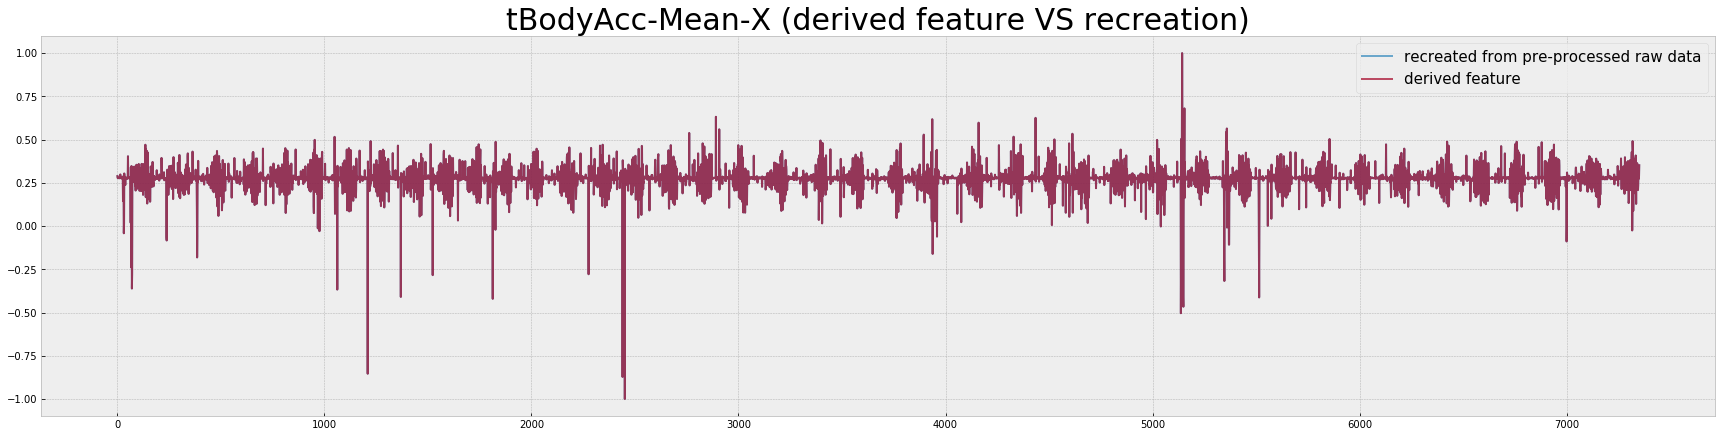

Distance betweeen recreation and derived feature for tBodyAcc-Mean-X is:  5.990437230929272e-05


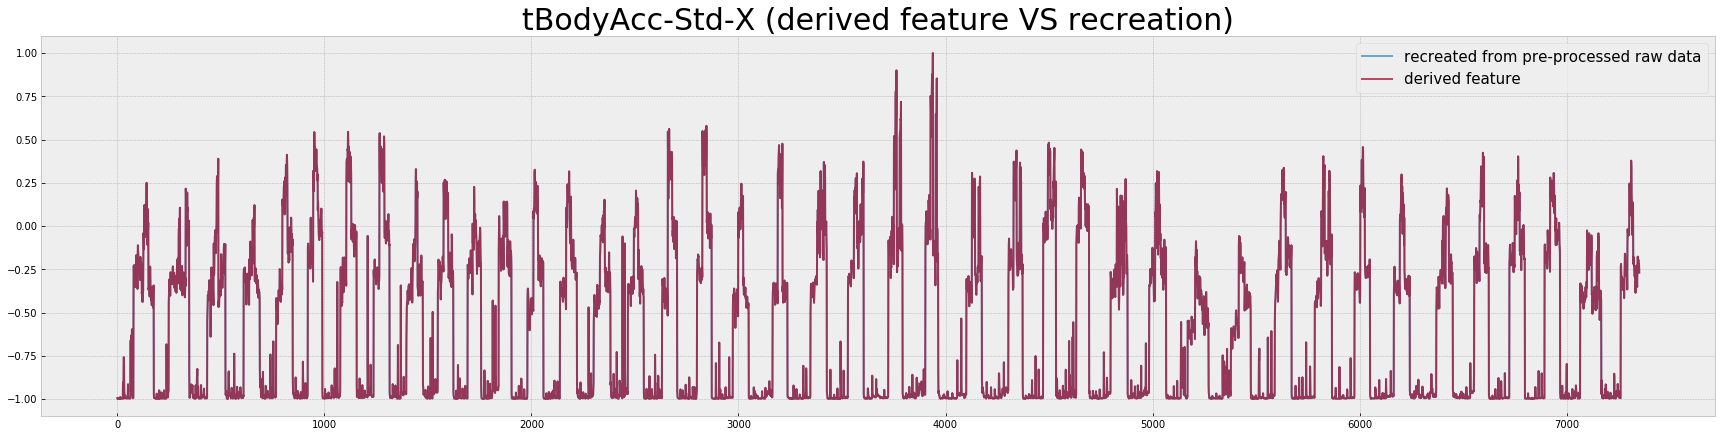

Distance betweeen recreation and derived feature for tBodyAcc-Std-X is:  5.263854535071243e-05


In [4]:
#recreate the derived feature from pre-processed raw data
mean_x = body_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
norm_mean_x = np.array([(2*(i-min(mean_x))/(max(mean_x)-min(mean_x)))-1 for i in mean_x])
tBodyAccMean_x = df_x_train.iloc[:,0] #tBodyAcc-Mean for X axis is in the first column
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(norm_mean_x,alpha=0.7,label="recreated from pre-processed raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS recreation)',fontsize=30)
plt.show()
distance = m._dtw_distance(norm_mean_x,tBodyAccMean_x)
print("Distance betweeen recreation and derived feature for tBodyAcc-Mean-X is: ",distance)

#recreate the derived feature from pre-processed raw data
std_x = body_acc_x.std(axis=1)
## normalize the mean betweeen 1 and -1
norm_std_x = np.array([(2*(i-min(std_x))/(max(std_x)-min(std_x)))-1 for i in std_x])
tBodyAccStd_x = df_x_train.iloc[:,3] #tBodyAcc-Mean for X axis is in the first column
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(norm_std_x,alpha=0.7,label="recreated from pre-processed raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Std-X (derived feature VS recreation)',fontsize=30)
plt.show()
distance = m._dtw_distance(norm_std_x,tBodyAccStd_x)
print("Distance betweeen recreation and derived feature for tBodyAcc-Std-X is: ",distance)

### DTW for filtered (and then calculated) and derived feature 
Now, let's work on raw data that is not pre-processed (total-acc data) <br/>
We'll start with feature: tBodyAcc-Mean-X

In [5]:
#prepare data to filter
data=np.concatenate((total_acc_x.iloc[0,:].values,total_acc_x.iloc[1,:].values))
for i in range(2,total_acc_x.shape[0]):
    data=np.concatenate((data,total_acc_x.iloc[i,:].values))

# Low pass filter
b,a = scipy.signal.butter(N=3,Wn=0.012,btype='low')
low_pass_total_acc_x = scipy.signal.lfilter(b,a,data) 
low_pass_total_acc_x = low_pass_total_acc_x.reshape(body_acc_x.shape)
# High Pass filter
b,a = scipy.signal.butter(N=3,Wn=0.012,btype='high')
high_pass_total_acc_x = scipy.signal.lfilter(b,a,data) 
high_pass_total_acc_x = high_pass_total_acc_x.reshape(body_acc_x.shape)

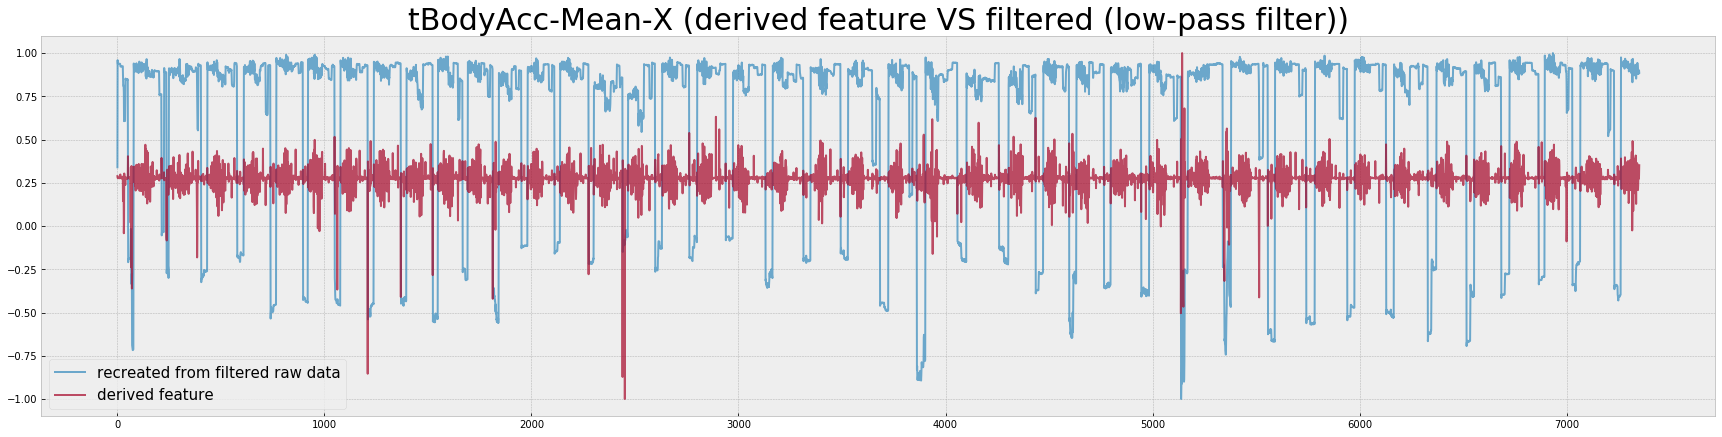

Distance betweeen low-pass filtered and derived feature for tBodyAcc-Mean-X is:  2889.9591682920104


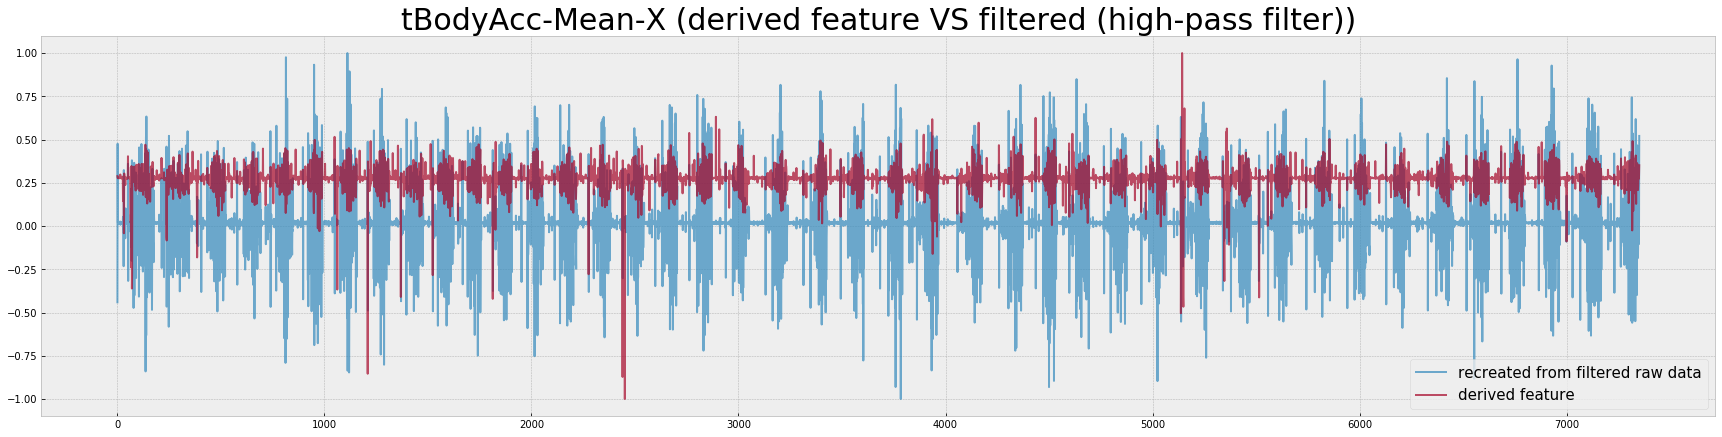

Distance betweeen high-pass filtered and derived feature for tBodyAcc-Mean-X is:  1029.374550422261


In [24]:
# derived feature to compare against
tBodyAccMean_x = df_x_train.iloc[:,0] #tBodyAcc-Mean for X axis is in the first column

#calculate the low pass filtered data to get derived data
low_pass_mean_x = low_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
low_pass_norm_mean_x = np.array([(2*(i-min(low_pass_mean_x))/(max(low_pass_mean_x)-min(low_pass_mean_x)))-1 for i in low_pass_mean_x])
# get the derived feature to compare against
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(low_pass_norm_mean_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS filtered (low-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(low_pass_norm_mean_x,tBodyAccMean_x)
print("Distance betweeen low-pass filtered and derived feature for tBodyAcc-Mean-X is: ",distance)


#calculate the high pass filtered data to get derived data
high_pass_mean_x = high_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
high_pass_norm_mean_x = np.array([(2*(i-min(high_pass_mean_x))/(max(high_pass_mean_x)-min(high_pass_mean_x)))-1 for i in high_pass_mean_x])
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(high_pass_norm_mean_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS filtered (high-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(high_pass_norm_mean_x,tBodyAccMean_x)
print("Distance betweeen high-pass filtered and derived feature for tBodyAcc-Mean-X is: ",distance)

Standard Deviation

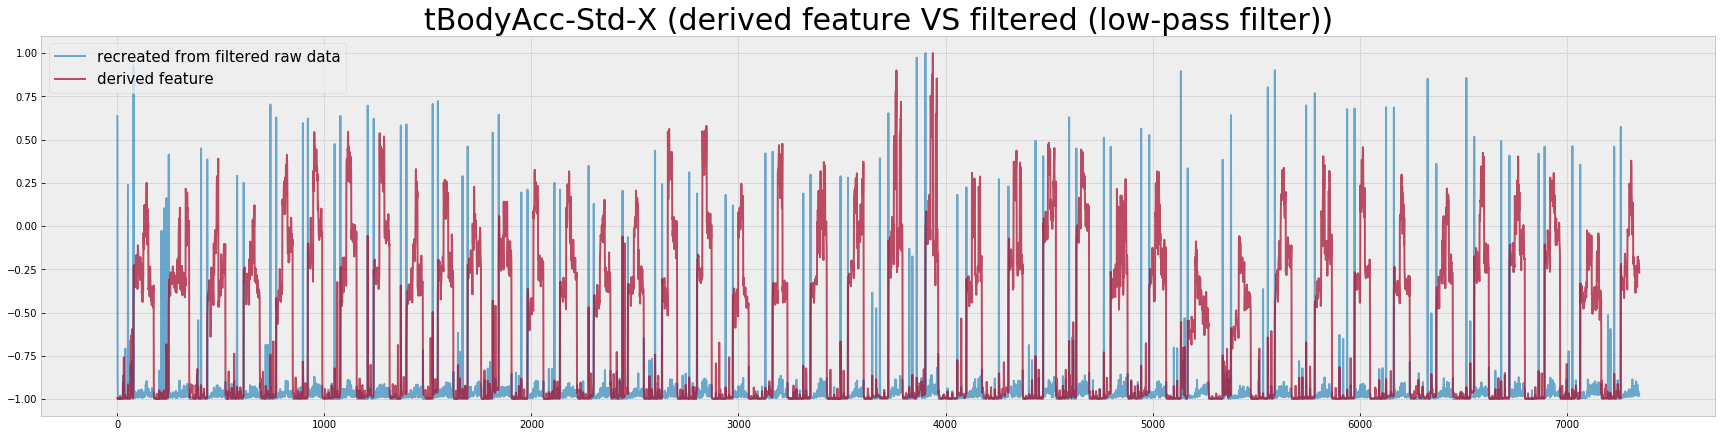

Distance betweeen low-pass filtered and derived feature for tBodyAcc-Std-X is:  1308.9027152116714


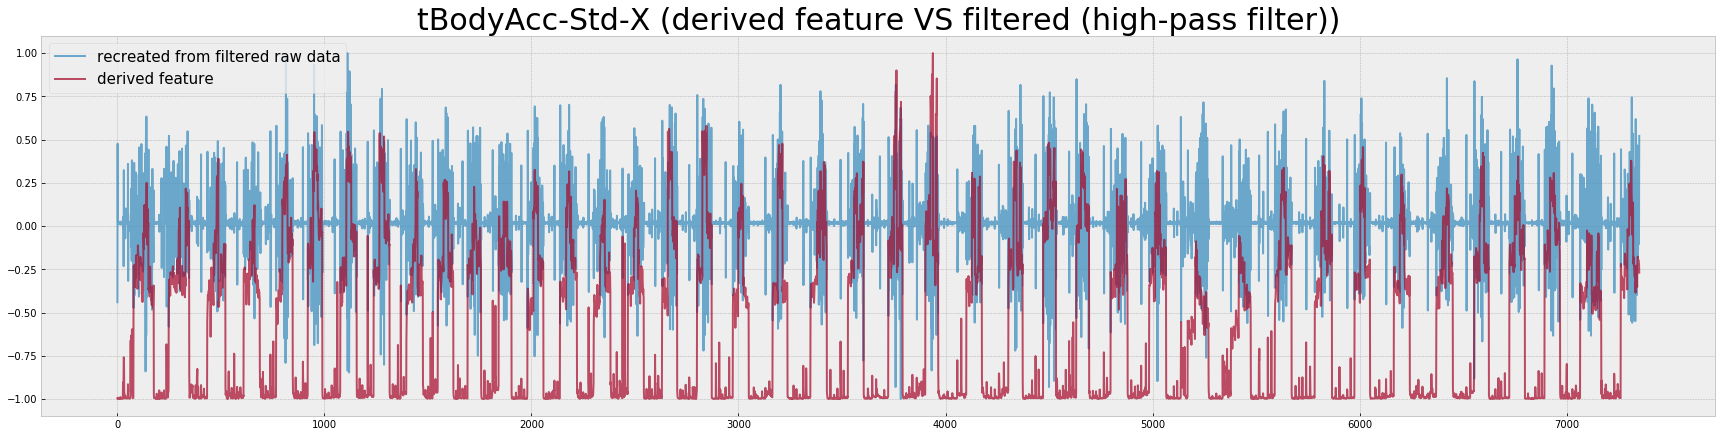

Distance betweeen high-pass filtered and derived feature for tBodyAcc-Std-X is:  2030.4576307389168


In [7]:
# derived feature to compare against
tBodyAccStd_x = df_x_train.iloc[:,3] #tBodyAcc-Mean for X axis is in the 4th column

#calculate the low pass filtered data to get derived data
low_pass_std_x = low_pass_total_acc_x.std(axis=1)
## normalize the mean betweeen 1 and -1
low_pass_norm_std_x = np.array([(2*(i-min(low_pass_std_x))/(max(low_pass_std_x)-min(low_pass_std_x)))-1 for i in low_pass_std_x])
# get the derived feature to compare against
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(low_pass_norm_std_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Std-X (derived feature VS filtered (low-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(low_pass_norm_std_x,tBodyAccStd_x)
print("Distance betweeen low-pass filtered and derived feature for tBodyAcc-Std-X is: ",distance)


#calculate the high pass filtered data to get derived data
high_pass_std_x = high_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
high_pass_norm_std_x = np.array([(2*(i-min(high_pass_std_x))/(max(high_pass_std_x)-min(high_pass_std_x)))-1 for i in high_pass_std_x])
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(high_pass_norm_std_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Std-X (derived feature VS filtered (high-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(high_pass_norm_std_x,tBodyAccStd_x)
print("Distance betweeen high-pass filtered and derived feature for tBodyAcc-Std-X is: ",distance)

### Model Performance and Prediction

In [16]:
m = KnnDtw(n_neighbors=1, max_warping_window=10) #should change to Dataframe.values()
x_train = body_acc_x_train.as_matrix()
y_train = body_acc_y_train.as_matrix()
z_train = body_acc_z_train.as_matrix()
activity_train = df_y_train.as_matrix()
x_test = body_acc_x_test.as_matrix()
y_test = body_acc_y_test.as_matrix()
z_test = body_acc_z_test.as_matrix()
activity_test = df_y_test.as_matrix()

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: Futur

For the x-axis

In [14]:
m.fit(x_train[::10], activity_train[::10])
label, proba = m.predict(x_test[::10])

 [**************   37%                  ]  80250 of 217120 complete                  0%                  ]  504 of 217120 complete [                  0%                  ]  573 of 217120 complete  [                  0%                  ]  897 of 217120 complete  [                  1%                  ]  1135 of 217120 complete  [                  1%                  ]  1563 of 217120 complete        [                  1%                  ]  2742 of 217120 complete [                  1%                  ]  2949 of 217120 complete                 [*                 2%                  ]  5416 of 217120 complete [*                 3%                  ]  5515 of 217120 complete  [*                 3%                  ]  5655 of 217120 complete [*                 3%                  ]  5725 of 217120 complete      [*                 3%                  ]  7177 of 217120 complete [*                 3%                  ]  7592 of 217120 complete             [**                4%              

 [*****************56%*                 ]  121915 of 217120 complete **************   37%                  ]  80258 of 217120 complete [**************   37%                  ]  80275 of 217120 complete [**************   37%                  ]  80394 of 217120 complete [**************   37%                  ]  80501 of 217120 complete  [**************   37%                  ]  80829 of 217120 complete [**************   37%                  ]  80838 of 217120 complete [**************   37%                  ]  80890 of 217120 complete [**************   37%                  ]  81379 of 217120 complete   [**************   38%                  ]  82027 of 217120 complete [**************   38%                  ]  82165 of 217120 complete [**************   38%                  ]  82623 of 217120 complete     [***************  39%                  ]  83766 of 217120 complete [***************  39%                  ]  83772 of 217120 complete [***************  39%                  ]  83880 of 217

 [*****************77%*********         ]  166411 of 217120 complete [*****************56%*                 ]  122020 of 217120 complete [*****************56%*                 ]  122068 of 217120 complete   [*****************57%**                ]  122876 of 217120 complete [*****************57%**                ]  122878 of 217120 complete [*****************57%**                ]  122886 of 217120 complete [*****************57%**                ]  122973 of 217120 complete  [*****************57%**                ]  123136 of 217120 complete             [*****************58%**                ]  125607 of 217120 complete      [*****************59%**                ]  127033 of 217120 complete      [*****************59%**                ]  127974 of 217120 complete      [*****************59%**                ]  129124 of 217120 complete [*****************60%***               ]  129231 of 217120 complete    [*****************60%***               ]  129516 of 217120 complete   [***********

 [*****************92%***************   ]  199934 of 217120 complete [*****************77%*********         ]  166557 of 217120 complete  [*****************77%*********         ]  166989 of 217120 complete  [*****************77%*********         ]  167262 of 217120 complete   [*****************77%*********         ]  167346 of 217120 complete     [*****************77%*********         ]  168218 of 217120 complete [*****************78%**********        ]  168536 of 217120 complete   [*****************78%**********        ]  169493 of 217120 complete [*****************78%**********        ]  169587 of 217120 complete [*****************78%**********        ]  169854 of 217120 complete     [*****************79%**********        ]  170557 of 217120 complete    [*****************79%**********        ]  170890 of 217120 complete [*****************79%**********        ]  170902 of 217120 complete [*****************79%**********        ]  170908 of 217120 complete [*****************79%*********

 [****************100%******************]  217120 of 217120 complete [*****************92%***************   ]  199960 of 217120 complete [*****************92%***************   ]  200261 of 217120 complete  [*****************92%***************   ]  200580 of 217120 complete [*****************93%***************   ]  201433 of 217120 complete    [*****************93%***************   ]  201677 of 217120 complete  [*****************93%***************   ]  201959 of 217120 complete [*****************93%***************   ]  201962 of 217120 complete  [*****************93%***************   ]  202087 of 217120 complete     [*****************93%***************   ]  202783 of 217120 complete [*****************93%***************   ]  202997 of 217120 complete  [*****************94%****************  ]  203124 of 217120 complete  [*****************94%****************  ]  203257 of 217120 complete    [*****************94%****************  ]  203505 of 217120 complete [*****************94%***********

                    precision    recall  f1-score   support

           WALKING       0.96      0.87      0.91        55
  WALKING_UPSTAIRS       0.90      0.69      0.78        62
WALKING_DOWNSTAIRS       0.57      1.00      0.72        25
           SITTING       0.27      0.24      0.26        58
          STANDING       0.46      0.36      0.40        64
            LAYING       0.44      0.74      0.55        31

         micro avg       0.60      0.60      0.60       295
         macro avg       0.60      0.65      0.61       295
      weighted avg       0.62      0.60      0.59       295



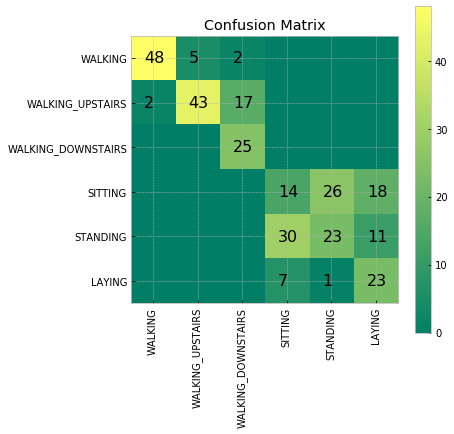

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(label, activity_test[::10],
                            target_names=[l for l in labels.iloc[:,1].values]))

conf_mat = confusion_matrix(label, activity_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.iloc[:,1].values], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.iloc[:,1].values])

y-axis

In [19]:
m.fit(y_train[::10], activity_train[::10])
label, proba = m.predict(y_test[::10])

 [****             11%                  ]  24538 of 217120 complete                  0%                  ]  99 of 217120 complete    [                  0%                  ]  213 of 217120 complete [                  0%                  ]  250 of 217120 complete [                  0%                  ]  279 of 217120 complete [                  0%                  ]  281 of 217120 complete [                  0%                  ]  440 of 217120 complete    [                  0%                  ]  546 of 217120 complete [                  0%                  ]  569 of 217120 complete [                  0%                  ]  573 of 217120 complete [                  0%                  ]  686 of 217120 complete [                  0%                  ]  699 of 217120 complete [                  0%                  ]  726 of 217120 complete [                  0%                  ]  766 of 217120 complete [                  0%                  ]  841 of 217120 complete   [                

 [*************    35%                  ]  75172 of 217120 complete [****             11%                  ]  24758 of 217120 complete   [*****            12%                  ]  25372 of 217120 complete [*****            12%                  ]  25556 of 217120 complete  [*****            12%                  ]  25963 of 217120 complete [*****            12%                  ]  26048 of 217120 complete [*****            12%                  ]  26158 of 217120 complete  [*****            12%                  ]  26437 of 217120 complete [*****            12%                  ]  26449 of 217120 complete  [*****            12%                  ]  26913 of 217120 complete [*****            12%                  ]  27134 of 217120 complete  [*****            13%                  ]  27370 of 217120 complete [*****            13%                  ]  27452 of 217120 complete [*****            13%                  ]  27884 of 217120 complete [*****            13%                  ]  27995 of 2171

 [*****************47%                  ]  102910 of 217120 complete *************    35%                  ]  75744 of 217120 complete [*************    35%                  ]  75878 of 217120 complete [*************    35%                  ]  75904 of 217120 complete [*************    35%                  ]  76017 of 217120 complete [*************    35%                  ]  76142 of 217120 complete [*************    35%                  ]  76225 of 217120 complete [*************    35%                  ]  76379 of 217120 complete [*************    35%                  ]  76428 of 217120 complete [*************    35%                  ]  76473 of 217120 complete  [*************    35%                  ]  76535 of 217120 complete [*************    35%                  ]  76639 of 217120 complete  [*************    35%                  ]  76753 of 217120 complete     [**************   36%                  ]  78112 of 217120 complete     [**************   36%                  ]  78594 of 

 [*****************58%**                ]  126963 of 217120 complete     [*****************48%                  ]  103177 of 217120 complete  [*****************48%                  ]  103588 of 217120 complete [*****************48%                  ]  103938 of 217120 complete [*****************48%                  ]  103971 of 217120 complete [*****************48%                  ]  104007 of 217120 complete  [*****************48%                  ]  104553 of 217120 complete [*****************48%                  ]  104676 of 217120 complete [*****************48%                  ]  104776 of 217120 complete  [*****************48%                  ]  105068 of 217120 complete [*****************48%                  ]  105217 of 217120 complete   [*****************49%                  ]  105577 of 217120 complete [*****************49%                  ]  105830 of 217120 complete   [*****************49%                  ]  106068 of 217120 complete [*****************49%               

 [*****************69%******            ]  148799 of 217120 complete [*****************59%**                ]  127170 of 217120 complete  [*****************59%**                ]  127272 of 217120 complete  [*****************59%**                ]  127416 of 217120 complete  [*****************59%**                ]  127579 of 217120 complete  [*****************59%**                ]  128429 of 217120 complete   [*****************59%**                ]  128586 of 217120 complete     [*****************60%***               ]  129669 of 217120 complete [*****************60%***               ]  129720 of 217120 complete [*****************60%***               ]  130009 of 217120 complete [*****************60%***               ]  130062 of 217120 complete  [*****************60%***               ]  130178 of 217120 complete [*****************60%***               ]  130300 of 217120 complete [*****************60%***               ]  130412 of 217120 complete   [*****************60%***          

 [*****************76%*********         ]  163988 of 217120 complete   [*****************69%******            ]  149168 of 217120 complete [*****************69%******            ]  149175 of 217120 complete [*****************69%******            ]  149272 of 217120 complete  [*****************69%******            ]  149353 of 217120 complete [*****************69%******            ]  149367 of 217120 complete  [*****************69%******            ]  149511 of 217120 complete  [*****************69%******            ]  149796 of 217120 complete    [*****************69%******            ]  150512 of 217120 complete [*****************69%******            ]  150718 of 217120 complete    [*****************70%*******           ]  151099 of 217120 complete [*****************70%*******           ]  151174 of 217120 complete  [*****************70%*******           ]  151658 of 217120 complete [*****************70%*******           ]  151683 of 217120 complete [*****************70%*******       

 [*****************82%***********       ]  178832 of 217120 complete [*****************76%*********         ]  164234 of 217120 complete     [*****************76%*********         ]  164415 of 217120 complete [*****************76%*********         ]  164452 of 217120 complete [*****************76%*********         ]  164565 of 217120 complete  [*****************76%*********         ]  164755 of 217120 complete [*****************76%*********         ]  164846 of 217120 complete [*****************76%*********         ]  164992 of 217120 complete [*****************76%*********         ]  165190 of 217120 complete [*****************76%*********         ]  165220 of 217120 complete [*****************76%*********         ]  165244 of 217120 complete [*****************76%*********         ]  165246 of 217120 complete  [*****************76%*********         ]  165410 of 217120 complete [*****************76%*********         ]  165520 of 217120 complete [*****************76%*********         ] 

 [*****************88%*************     ]  191984 of 217120 complete   [*****************82%***********       ]  179017 of 217120 complete  [*****************83%************      ]  179168 of 217120 complete  [*****************83%************      ]  179245 of 217120 complete    [*****************83%************      ]  179591 of 217120 complete [*****************83%************      ]  179593 of 217120 complete  [*****************83%************      ]  179831 of 217120 complete [*****************83%************      ]  180182 of 217120 complete [*****************83%************      ]  180350 of 217120 complete [*****************83%************      ]  180465 of 217120 complete [*****************83%************      ]  180544 of 217120 complete [*****************83%************      ]  180577 of 217120 complete [*****************83%************      ]  180640 of 217120 complete [*****************83%************      ]  180679 of 217120 complete [*****************83%************      

 [****************100%******************]  217120 of 217120 complete [*****************88%*************     ]  192046 of 217120 complete  [*****************89%**************    ]  192200 of 217120 complete [*****************89%**************    ]  192269 of 217120 complete  [*****************89%**************    ]  192449 of 217120 complete  [*****************89%**************    ]  192574 of 217120 complete [*****************89%**************    ]  192593 of 217120 complete [*****************89%**************    ]  192597 of 217120 complete    [*****************89%**************    ]  192819 of 217120 complete  [*****************89%**************    ]  193132 of 217120 complete [*****************89%**************    ]  193225 of 217120 complete [*****************89%**************    ]  193290 of 217120 complete [*****************89%**************    ]  193514 of 217120 complete [*****************89%**************    ]  193599 of 217120 complete   [*****************89%**************   

                    precision    recall  f1-score   support

           WALKING       0.90      0.69      0.78        65
  WALKING_UPSTAIRS       0.83      0.78      0.81        51
WALKING_DOWNSTAIRS       0.48      0.84      0.61        25
           SITTING       0.39      0.36      0.37        56
          STANDING       0.36      0.45      0.40        40
            LAYING       0.52      0.47      0.49        58

         micro avg       0.58      0.58      0.58       295
         macro avg       0.58      0.60      0.58       295
      weighted avg       0.61      0.58      0.59       295



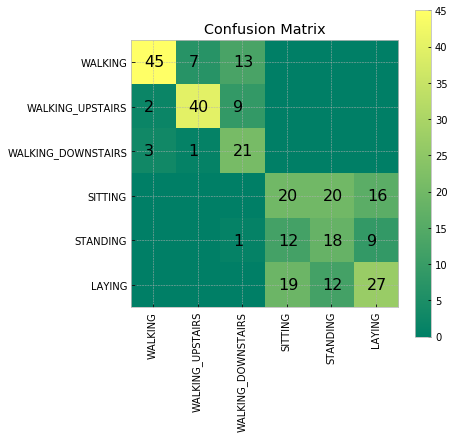

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(label, activity_test[::10],
                            target_names=[l for l in labels.iloc[:,1].values]))

conf_mat = confusion_matrix(label, activity_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.iloc[:,1].values], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.iloc[:,1].values])

z axis

In [21]:
m.fit(z_train[::10], activity_train[::10])
label, proba = m.predict(z_test[::10])

 [****             10%                  ]  20779 of 217120 complete                  0%                  ]  163 of 217120 complete [                  0%                  ]  182 of 217120 complete    [                  0%                  ]  537 of 217120 complete  [                  0%                  ]  1052 of 217120 complete  [                  1%                  ]  1121 of 217120 complete        [                  1%                  ]  2262 of 217120 complete [                  1%                  ]  2690 of 217120 complete     [*                 2%                  ]  3404 of 217120 complete [*                 2%                  ]  3919 of 217120 complete [*                 2%                  ]  3975 of 217120 complete   [*                 2%                  ]  4769 of 217120 complete [*                 2%                  ]  4782 of 217120 complete  [*                 2%                  ]  4964 of 217120 complete  [*                 2%                  ]  5189 of 217120 co

 [********         22%                  ]  46911 of 217120 complete [****             10%                  ]  20789 of 217120 complete [****             10%                  ]  20800 of 217120 complete  [****             10%                  ]  21010 of 217120 complete [****             10%                  ]  21024 of 217120 complete [****             10%                  ]  21059 of 217120 complete    [****             10%                  ]  21193 of 217120 complete   [****             10%                  ]  21377 of 217120 complete [****             10%                  ]  21459 of 217120 complete  [****             10%                  ]  21591 of 217120 complete   [****             10%                  ]  21805 of 217120 complete  [****             10%                  ]  21859 of 217120 complete [****             10%                  ]  21927 of 217120 complete [****             10%                  ]  21952 of 217120 complete  [****             10%                  ]  22340 of

 [*************    34%                  ]  72943 of 217120 complete      [********         22%                  ]  47586 of 217120 complete [********         22%                  ]  47647 of 217120 complete [********         22%                  ]  47707 of 217120 complete  [********         22%                  ]  47922 of 217120 complete  [********         22%                  ]  47944 of 217120 complete  [********         22%                  ]  48422 of 217120 complete  [********         22%                  ]  48759 of 217120 complete  [********         22%                  ]  48847 of 217120 complete [*********        23%                  ]  48864 of 217120 complete [*********        23%                  ]  48988 of 217120 complete [*********        23%                  ]  49142 of 217120 complete [*********        23%                  ]  49203 of 217120 complete [*********        23%                  ]  49341 of 217120 complete [*********        23%                  ]  49665 of 

 [*****************45%                  ]  97615 of 217120 complete  [*************    34%                  ]  73106 of 217120 complete [*************    34%                  ]  73131 of 217120 complete [*************    34%                  ]  73203 of 217120 complete [*************    34%                  ]  73904 of 217120 complete [*************    34%                  ]  73974 of 217120 complete  [*************    34%                  ]  74598 of 217120 complete [*************    35%                  ]  74974 of 217120 complete  [*************    35%                  ]  75263 of 217120 complete  [*************    35%                  ]  75593 of 217120 complete   [*************    35%                  ]  75758 of 217120 complete [*************    35%                  ]  75942 of 217120 complete    [*************    35%                  ]  76370 of 217120 complete [*************    35%                  ]  76669 of 217120 complete [*************    35%                  ]  76935 of 2

 [*****************59%**                ]  127306 of 217120 complete *****************45%                  ]  97770 of 217120 complete [*****************45%                  ]  97925 of 217120 complete [*****************45%                  ]  97991 of 217120 complete [*****************45%                  ]  98131 of 217120 complete [*****************46%                  ]  98911 of 217120 complete [*****************46%                  ]  99155 of 217120 complete [*****************46%                  ]  99178 of 217120 complete [*****************46%                  ]  99182 of 217120 complete [*****************46%                  ]  99498 of 217120 complete [*****************46%                  ]  99618 of 217120 complete [*****************46%                  ]  99638 of 217120 complete [*****************46%                  ]  99695 of 217120 complete  [*****************46%                  ]  100205 of 217120 complete [*****************46%                  ]  100715 of 217120 

 [*****************71%*******           ]  154182 of 217120 complete [*****************59%**                ]  127808 of 217120 complete [*****************59%**                ]  128056 of 217120 complete [*****************59%**                ]  128202 of 217120 complete [*****************59%**                ]  128247 of 217120 complete  [*****************59%**                ]  128722 of 217120 complete  [*****************60%***               ]  129920 of 217120 complete [*****************60%***               ]  129929 of 217120 complete [*****************60%***               ]  130575 of 217120 complete   [*****************61%***               ]  131441 of 217120 complete [*****************61%***               ]  131548 of 217120 complete    [*****************61%***               ]  132018 of 217120 complete [*****************61%***               ]  132160 of 217120 complete  [*****************61%***               ]  132419 of 217120 complete [*****************61%***               

 [****************100%******************]  216126 of 217120 complete [*****************71%*******           ]  154385 of 217120 complete      [*****************72%*******           ]  155394 of 217120 complete    [*****************72%*******           ]  156377 of 217120 complete [*****************72%*******           ]  156740 of 217120 complete [*****************72%*******           ]  156794 of 217120 complete  [*****************72%*******           ]  157014 of 217120 complete [*****************72%*******           ]  157048 of 217120 complete [*****************72%*******           ]  157093 of 217120 complete [*****************73%********          ]  157534 of 217120 complete [*****************73%********          ]  157810 of 217120 complete  [*****************73%********          ]  158266 of 217120 complete [*****************73%********          ]  158399 of 217120 complete [*****************73%********          ]  158423 of 217120 complete [*****************73%********        

 [****************100%******************]  217120 of 217120 complete 

                    precision    recall  f1-score   support

           WALKING       0.72      0.57      0.64        63
  WALKING_UPSTAIRS       0.77      0.76      0.76        49
WALKING_DOWNSTAIRS       0.48      0.70      0.57        30
           SITTING       0.22      0.25      0.23        44
          STANDING       0.26      0.29      0.27        45
            LAYING       0.54      0.44      0.48        64

         micro avg       0.49      0.49      0.49       295
         macro avg       0.50      0.50      0.49       295
      weighted avg       0.52      0.49      0.50       295



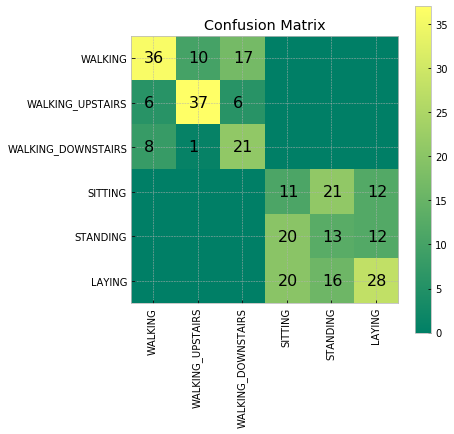

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(label, activity_test[::10],
                            target_names=[l for l in labels.iloc[:,1].values]))

conf_mat = confusion_matrix(label, activity_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.iloc[:,1].values], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.iloc[:,1].values])

### Part B
Plot the yearly temperature for the following countries: Norway, Finland, Singapore and Cambodia.
Use DTW to measure the similarities between the temperature data of these countries and reflect on
the results.

In [26]:
m=KnnDtw()
# data imports
GlobalLandTempByCountry = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByCountry.csv", sep=',')
GlobalLandTempByMajorCity = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByMajorCity.csv", sep=',')
GlobalLandTempByState = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByState.csv", sep=',')
GlobalTemp = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalTemperatures.csv", sep=',')

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


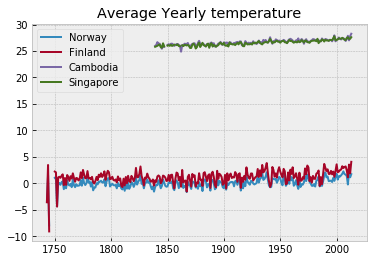

DTW Difference btweeen countries is: 
              Cambodia      Finland       Norway    Singapore
Cambodia      0.000000  3813.756500  3991.848583    23.042750
Finland    3813.756500     0.000000   126.774333  3792.487167
Norway     3991.848583   126.774333     0.000000  3970.579250
Singapore    23.042750  3792.487167  3970.579250     0.000000


In [27]:
### need to average by year ###
mask_norway = [GlobalLandTempByCountry.Country=="Norway"]
NorwayTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_norway)]
NorwayTemp.loc[:,'year'] = pd.DatetimeIndex(NorwayTemp['dt'],yearfirst=True).year
# get mean temperature by year
NorwayTemp.loc[:, 'AverageYearlyTemp'] = NorwayTemp.groupby(NorwayTemp.year)['AverageTemperature'].transform('mean')
NorwayYearlyTemp = NorwayTemp.loc[:,['AverageYearlyTemp','year']]
NorwayYearlyTemp = NorwayYearlyTemp.drop_duplicates()
plt.plot(NorwayYearlyTemp.year,NorwayYearlyTemp.AverageYearlyTemp, label='Norway')
#plt.title("Norway Temperature")
#plt.show()
mask_finland = [GlobalLandTempByCountry.Country=="Finland"]
FinlandTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_finland)]
FinlandTemp.loc[:,'year'] = pd.DatetimeIndex(FinlandTemp['dt'],yearfirst=True).year
#get mean temp by year
FinlandTemp.loc[:, 'AverageYearlyTemp'] = FinlandTemp.groupby(FinlandTemp.year)['AverageTemperature'].transform('mean')
FinlandYearlyTemp = FinlandTemp.loc[:,['AverageYearlyTemp','year']]
FinlandYearlyTemp = FinlandYearlyTemp.drop_duplicates()
plt.plot(FinlandYearlyTemp.year,FinlandYearlyTemp.AverageYearlyTemp, label='Finland')
#plt.title("Finland Temperature")
#plt.show()
mask_cambodia = [GlobalLandTempByCountry.Country=="Cambodia"]
CambodiaTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_cambodia)]
CambodiaTemp.loc[:,'year'] = pd.DatetimeIndex(CambodiaTemp['dt'],yearfirst=True).year
CambodiaTemp.loc[:, 'AverageYearlyTemp'] = CambodiaTemp.groupby(CambodiaTemp.year)['AverageTemperature'].transform('mean')
CambodiaYearlyTemp = CambodiaTemp.loc[:,['AverageYearlyTemp','year']]
CambodiaYearlyTemp = CambodiaYearlyTemp.drop_duplicates()
plt.plot(CambodiaYearlyTemp.year,CambodiaYearlyTemp.AverageYearlyTemp, label='Cambodia')
#plt.title("Cambodia Temperature")
#plt.show()
mask_sg = [GlobalLandTempByCountry.Country=="Singapore"]
SingaporeTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_sg)]
SingaporeTemp.loc[:,'year'] = pd.DatetimeIndex(SingaporeTemp['dt'],yearfirst=True).year
SingaporeTemp.loc[:, 'AverageYearlyTemp'] = SingaporeTemp.groupby(SingaporeTemp.year)['AverageTemperature'].transform('mean')
SingaporeYearlyTemp = SingaporeTemp.loc[:,['AverageYearlyTemp','year']]
SingaporeYearlyTemp = SingaporeYearlyTemp.drop_duplicates()
plt.plot(SingaporeYearlyTemp.year,SingaporeYearlyTemp.AverageYearlyTemp, label='Singapore')
#plt.title("Singapore Temperature")
#plt.show()
plt.title("Average Yearly temperature")
plt.legend()
plt.show()

# to avoid NaN values we only select values from year 1862 onwards
DTW_Cambodia = CambodiaYearlyTemp.loc[CambodiaYearlyTemp['year'] >1862].iloc[:,0].values
DTW_Norway = NorwayYearlyTemp.loc[NorwayYearlyTemp['year'] > 1862].iloc[:,0].values
DTW_Finland = FinlandYearlyTemp.loc[FinlandYearlyTemp['year']>1862].iloc[:,0].values
DTW_Singapore = SingaporeYearlyTemp.loc[SingaporeYearlyTemp['year']>1862].iloc[:,0].values

diff_matrix=[
    [m._dtw_distance(DTW_Cambodia,DTW_Cambodia),m._dtw_distance(DTW_Cambodia,DTW_Finland),m._dtw_distance(DTW_Cambodia,DTW_Norway),m._dtw_distance(DTW_Cambodia,DTW_Singapore)],
    [m._dtw_distance(DTW_Finland,DTW_Cambodia),m._dtw_distance(DTW_Finland,DTW_Finland),m._dtw_distance(DTW_Finland,DTW_Norway),m._dtw_distance(DTW_Finland,DTW_Singapore)],
    [m._dtw_distance(DTW_Norway,DTW_Cambodia),m._dtw_distance(DTW_Norway,DTW_Finland),m._dtw_distance(DTW_Norway,DTW_Norway),m._dtw_distance(DTW_Norway,DTW_Singapore)],
    [m._dtw_distance(DTW_Singapore,DTW_Cambodia),m._dtw_distance(DTW_Singapore,DTW_Finland),m._dtw_distance(DTW_Singapore,DTW_Norway),m._dtw_distance(DTW_Singapore,DTW_Singapore)]]
print("DTW Difference btweeen countries is: ")
print(pd.DataFrame(diff_matrix, columns=['Cambodia','Finland','Norway','Singapore'], index=['Cambodia','Finland','Norway','Singapore']))